In [1]:
#If th openai api key is not set already, please set it here.
import os
if 'OPENAI_API_KEY' not in os.environ:  
     os.environ['OPENAI_API_KEY'] = 'your key'

In [9]:
from amadeusgpt import AMADEUS
from amadeusgpt.config import Config
import amadeusgpt
from amadeusgpt.utils import parse_result
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

In [12]:
amadeus_root = Path(amadeusgpt.__file__).parent.parent
config = Config(amadeus_root / "amadeusgpt/configs/MABe_template.yaml")
config['data_info']['data_folder'] = amadeus_root / config['data_info']['data_folder']

amadeus = AMADEUS(config)
video_file_paths = amadeus.get_video_file_paths()
print (video_file_paths)

['/Users/shaokaiye/AmadeusGPT-dev/examples/MABe/EGS8X2MN4SSUGFWAV976.mp4']


In [8]:
amadeus = AMADEUS(config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0 $
current total tokens 553
The image shows a top-down view of three small animals, likely mice, in a confined space with a textured floor. The background appears to be a controlled environment, possibly a laboratory setting. There is a vent or some sort of grid visible at the top of the image.

Here is the filled json string based on the description:

```json
{
    "description": "Top-down view of three small animals, likely mice, in a confined space with a textured floor. There is a vent or grid visible at the top of the image.",
    "individuals": 3,
    "species": "topview_mouse",
    "background_objects": ["vent"]
}
```


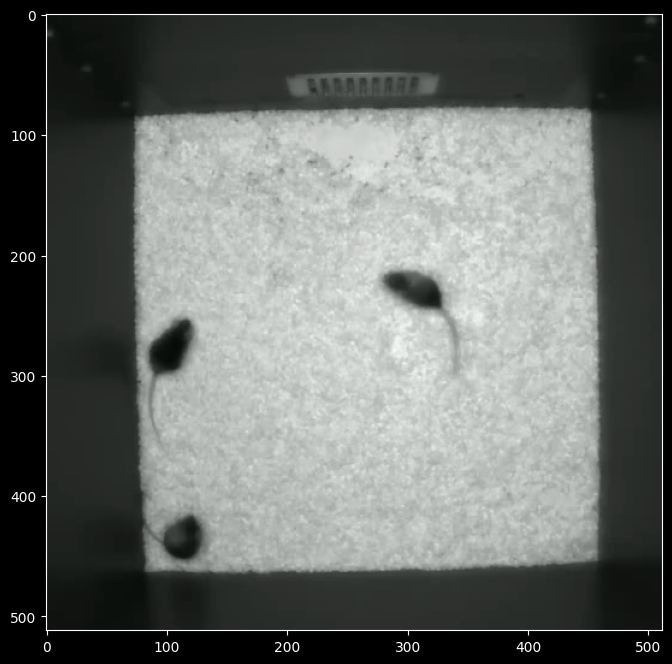

In [6]:
behavior_analysis = amadeus.get_behavior_analysis('/Users/shaokaiye/AmadeusGPT-dev/examples/MABe/EGS8X2MN4SSUGFWAV976.mp4')
scene_image = behavior_analysis.visual_manager.get_scene_image()
plt.imshow(scene_image)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


doing active forgetting


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0019 $
current input tokens 2909
current accumulated tokens 9411


The question can be answered by code using the provided APIs. We can capture the events where the distance between animals is less than 260 and greater than 50, and the head angle between animals is less than 15 degrees. 

We will use the `get_animals_animals_events` function to capture these events based on the specified conditions. 

Here is the code to achieve this:

```python
def get_watching_events(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    List[Event]
        A list of events where animals are watching each other based on the defined criteria.
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Define the queries for distance and head angle
    distance_query = ['distance<260', 'distance>50']
    head_angle_query = ['relative_head_angle<15']
    
    # Get events for distance between animals
    distance_events = analysis.get_animals_animals_events(cross_animal_query_list=distance_query,
                                                          min_window=11,
                                                          max_window=100000,
                                                          smooth_window_size=15)
    
    # Get events for head angle between animals
    head_angle_events = analysis.get_animals_animals_events(cross_animal_query_list=head_angle_query,
                                                             min_window=11,
                                                             max_window=100000,
                                                             smooth_window_size=15)
    
    # Combine the distance and head angle events
    watching_events = analysis.get_composite_events(distance_events,
                                                     head_angle_events,
                                                     composition_type="logical_and",
                                                     max_interval_between_sequential_events=15,
                                                     min_window=11,
                                                     max_window=100000)
    
    return watching_events
```

{}

videos generated to defaultdict(<class 'list'>, {'/Users/shaokaiye/AmadeusGPT-dev/examples/MABe/EGS8X2MN4SSUGFWAV976.mp4': ['results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_0.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_1.mp4', 'results/EGS8X2MN4SSUGFWAV976_get_watching_events_video_2.mp4']})
Open it with media player if it does not properly display in the notebook


[<amadeusgpt.analysis_objects.event.Event object at 0x2b1c145b0>, <amadeusgpt.analysis_objects.event.Event object at 0x2b1c146d0>, <amadeusgpt.analysis_objects.event.Event object at 0x2b2d34a90>]

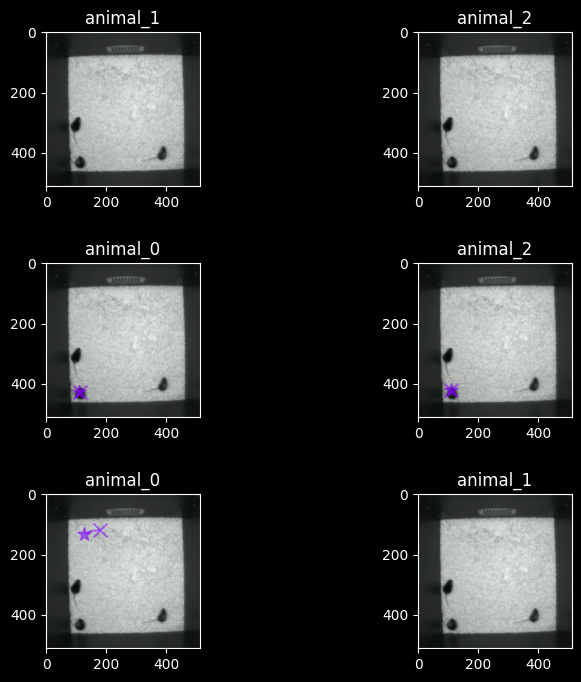

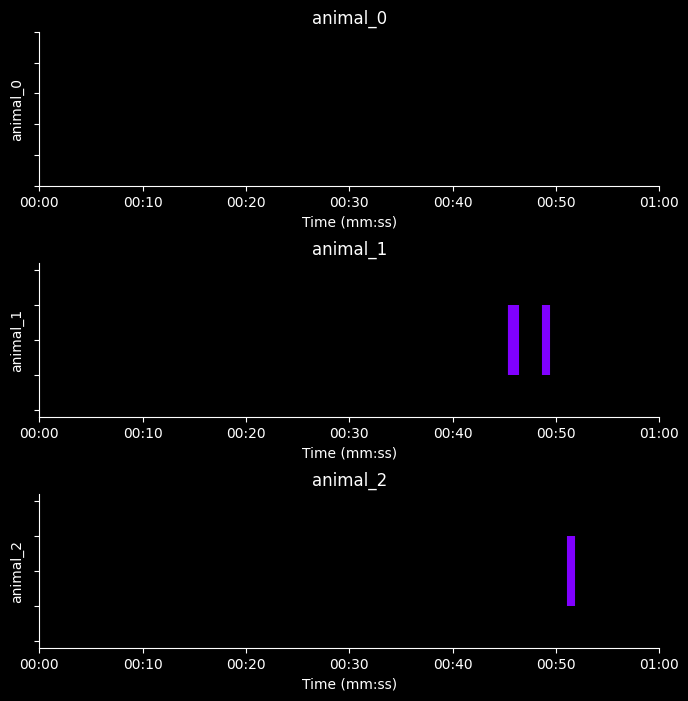

In [10]:
query = "Define watch as a social behavior where distance between animals is less than 260  \
and larger than 50 and head angle between animals is less than 15. The smooth_window_size is 15. Get watching"
qa_message = amadeus.step(query)
qa_message = parse_result(amadeus, qa_message)

### You can get a list of binary masks (equivalent to ethogram) for the underlying behavior, if your query is about retriving a described behavior

In [11]:
# the return masks is of shape (num_of_events, video_length)
# where each boolean array of (video_length,) is binary where True indicates whether the behavior is happening at that frame
masks = qa_message.get_masks()
print (masks)

{'/Users/shaokaiye/AmadeusGPT-dev/examples/MABe/EGS8X2MN4SSUGFWAV976.mp4': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
